In [1]:
import re

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from termcolor import colored
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from wordcloud import WordCloud
from PIL import Image
from imblearn.metrics import classification_report_imbalanced
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Data loading
- The data is located in the dataset directory
- Although at first glance the data is divided into a training and a test set, the test set does not contain an output variable and we cannot test how well the model works on it, so it is necessary to divide train.csv into a training and a test set. But it will be done only after preprocessing the text

In [3]:
data = pd.read_csv('dataset/train.csv')

In [4]:
(num_instances, num_attrs) = data.shape

print(f'Number of instances: {num_instances:,}')
print(f'Number of attributes: {num_attrs} ({", ".join(data.columns.values)})')

Number of instances: 31,962
Number of attributes: 3 (id, label, tweet)


# Data cleaning

In [5]:
pd.set_option('display.max_colwidth', 1000)

data.head(n=10)

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,5,0,factsguide: society now #motivation
5,6,0,[2/2] huge fan fare and big talking before they leave. chaos and pay disputes when they get there. #allshowandnogo
6,7,0,@user camping tomorrow @user @user @user @user @user @user @user dannyâ¦
7,8,0,the next school year is the year for exams.ð¯ can't think about that ð­ #school #exams #hate #imagine #actorslife #revolutionschool #girl
8,9,0,we won!!! love the land!!! #allin #cavs #champions #cleveland #clevelandcavaliers â¦
9,10,0,@user @user welcome here ! i'm it's so #gr8 !


Since attribute `id` is irrelevant we can drop it from the data

In [6]:
data.drop(['id'], axis=1, inplace=True)

data.head(n=10)

,label,tweet
0,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,0,bihday your majesty
3,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,0,factsguide: society now #motivation
5,0,[2/2] huge fan fare and big talking before they leave. chaos and pay disputes when they get there. #allshowandnogo
6,0,@user camping tomorrow @user @user @user @user @user @user @user dannyâ¦
7,0,the next school year is the year for exams.ð¯ can't think about that ð­ #school #exams #hate #imagine #actorslife #revolutionschool #girl
8,0,we won!!! love the land!!! #allin #cavs #champions #cleveland #clevelandcavaliers â¦
9,0,@user @user welcome here ! i'm it's so #gr8 !


### Handling null values

In [7]:
null_values = data.isna().any().any()

print('No null values') if not null_values else print(data.isna().sum())

No null values


Although there is no `NaN` value, it does not mean that our data set does not really have missing values, in our case an empty text or an empty tweet is also a missing value (although it is impossible to publish an empty tweet). After processing the text, it is possible to receive an empty tweet in case the content of the tweet is one of Stopwords, emoji, etc. which will be discussed below

In [8]:
print(len(data.loc[data['tweet'] == '']))

0


#### Some of the methods for handling null values
Since our set does not contain null values, there is no need for further analysis of missing data
In case there were null values, they could be processed in one of the following ways:

- *By dropping* (train_data.dropna(), where we have to take care not to drop too much data)

- *By filling with default values* (train_data.fillna(def), here the question is what to choose as a default value, in case we do not have a value for the label attribute, if we choose 0 tweets that contain hate speech can be characterized as tweets that do not contain speech hatred, similar for 1)

- *Forward / backward filling* (train_data['label'].ffill(), or train_data['label'].bfill())

    - ffill() fills a null value based on the value above it
    - bfill() fills a null value based on the value below it
- ...

After filling in the missing values, we can use the hist() method to check how much the data set really affected us

In [9]:
print(f'Has {len(data.loc[data["tweet"].duplicated() == True])} duplicates') if data.duplicated().any() else print('No duplicates')

Has 2432 duplicates


In [10]:
print(f'Number of instances before dropping duplicates: {data.shape[0]}')
data = data.drop_duplicates(keep='first')
print(f'Number of instances after dropping duplicates: {data.shape[0]}')

Number of instances before dropping duplicates: 31962
Number of instances after dropping duplicates: 29530


The next step is the processing of tweets in such a way that they do not contain `stopwords` ('I', 'myself', 'your', 'like' ...), `punctuation marks` (',', '!', '.' ..), `emojis` (':)', ';)', ...) etc. which cannot significantly affect the text. Lematization will also be performed, which reduces the words to their basic form (e.g. [improve, improving, improved], etc. will be reduced to improve) (In addition to lemmatization, there is also stemming, during which the last characters that lead to the wrong conclusion and spelling are removed)

In [11]:
stop_words = set(stopwords.words('english'))
stop_words.add('user')

lemma = WordNetLemmatizer()

In [12]:
def preprocessing_tweet(tweet: str) -> str:
    new_tweet = tweet.lower()
    new_tweet = re.sub(r'[^a-zA-Z]', ' ', new_tweet)
    new_tweet = [word for word in new_tweet.split() if word not in stop_words]
    new_tweet = ' '.join([lemma.lemmatize(word) for word in new_tweet])

    return new_tweet

In [13]:
data['tweet_cleaned'] = data['tweet'].apply(preprocessing_tweet)

data.head(n=10)

,label,tweet,tweet_cleaned
0,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,father dysfunctional selfish drag kid dysfunction run
1,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,thanks lyft credit use cause offer wheelchair van pdx disapointed getthanked
2,0,bihday your majesty,bihday majesty
3,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,model love u take u time ur
4,0,factsguide: society now #motivation,factsguide society motivation
5,0,[2/2] huge fan fare and big talking before they leave. chaos and pay disputes when they get there. #allshowandnogo,huge fan fare big talking leave chaos pay dispute get allshowandnogo
6,0,@user camping tomorrow @user @user @user @user @user @user @user dannyâ¦,camping tomorrow danny
7,0,the next school year is the year for exams.ð¯ can't think about that ð­ #school #exams #hate #imagine #actorslife #revolutionschool #girl,next school year year exam think school exam hate imagine actorslife revolutionschool girl
8,0,we won!!! love the land!!! #allin #cavs #champions #cleveland #clevelandcavaliers â¦,love land allin cavs champion cleveland clevelandcavaliers
9,0,@user @user welcome here ! i'm it's so #gr8 !,welcome gr


After processing the text, it may happen that tweet_cleaned is an empty string, in the case that the tweet consists only of tags, stopwords, etc. Therefore, it is necessary to determine how many such instances exist and how to process them

In [14]:
empty_tweets = data.loc[data['tweet_cleaned'] == '']
empty_tweets.shape

(37, 3)

As the number of instances is incomparably smaller than the total number of instances of the training data set, we can throw them out

In [15]:
print(f'Number of instances before dropping empty tweets: {data.shape[0]}')
data = data.loc[data['tweet_cleaned'] != '']
print(f'Number of instances after dropping empty tweets: {data.shape[0]}')

Number of instances before dropping empty tweets: 29530
Number of instances after dropping empty tweets: 29493


We add the length column, which we will need to determine outliers

In [16]:
data['length'] = data['tweet_cleaned'].str.len()
data.head(n=10)

,label,tweet,tweet_cleaned,length
0,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,father dysfunctional selfish drag kid dysfunction run,53
1,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,thanks lyft credit use cause offer wheelchair van pdx disapointed getthanked,76
2,0,bihday your majesty,bihday majesty,14
3,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,model love u take u time ur,27
4,0,factsguide: society now #motivation,factsguide society motivation,29
5,0,[2/2] huge fan fare and big talking before they leave. chaos and pay disputes when they get there. #allshowandnogo,huge fan fare big talking leave chaos pay dispute get allshowandnogo,68
6,0,@user camping tomorrow @user @user @user @user @user @user @user dannyâ¦,camping tomorrow danny,22
7,0,the next school year is the year for exams.ð¯ can't think about that ð­ #school #exams #hate #imagine #actorslife #revolutionschool #girl,next school year year exam think school exam hate imagine actorslife revolutionschool girl,90
8,0,we won!!! love the land!!! #allin #cavs #champions #cleveland #clevelandcavaliers â¦,love land allin cavs champion cleveland clevelandcavaliers,58
9,0,@user @user welcome here ! i'm it's so #gr8 !,welcome gr,10


# Splitting the data into `input / output` and `train / test`

In [17]:
X = data.drop(['label', 'tweet'], axis=1)
Y = data['label']

In [18]:
(X_train, X_test, Y_train, Y_test) = train_test_split(X, Y, stratify=Y, test_size=0.3, random_state=42)

In [19]:
print(f'Number of instances in train data: {X_train.shape[0]}')
print(f'Number of instances in test data: {X_test.shape[0]}')

Number of instances in train data: 20645
Number of instances in test data: 8848


# Outliers
In the case of text processing, the length of the text itself can affect the model itself. Namely, if some words are found in a longer text that are not important for tweet categorization, they can affect the readjustment of the model. After the cleaned tweets, a column with the length of each tweet was added. Then a Box plot is determined based on which we can see which instances represent outliers, after which the given outliers will be removed. It should be noted that the processing of outliers is performed after dividing the train and test data sets so that the test data set is not compromised.

In [20]:
train_data = pd.concat([X_train, Y_train], axis=1)
train_data.head()

,tweet_cleaned,length,label
22001,wait stage look awesome see pm cmafest drinkingwithdolly flockon,64,0
18793,bbc news orlando gay nightclub shooting killed suspect omar mateen love love get smh,84,0
14980,friend netflix,14,0
10457,ceain area yeah seen video seeing little kid cry,48,0
29761,thnx pilot nick amazing experience grandcanyon afternoon,56,0


In [21]:
hatred_tweets = train_data.loc[data['label'] == 1]['tweet_cleaned']
hatred_tweets_len = hatred_tweets.str.len()
non_hatred_tweets = train_data.loc[data['label'] == 0]['tweet_cleaned']
non_hatred_tweets_len = non_hatred_tweets.str.len()

Text(0.5, 1.0, 'Non-Hatred tweets length')

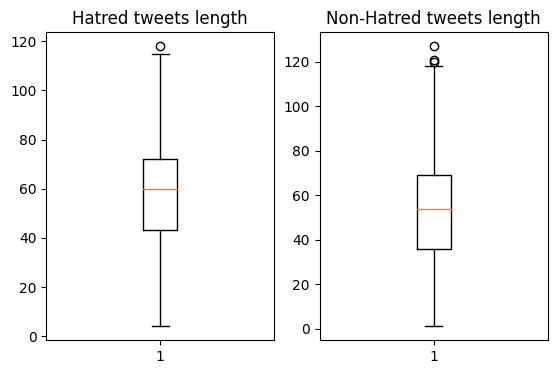

In [22]:
(hatred_Q1, hatred_Q3) = hatred_tweets_len.quantile([0.25, 0.75])
hatred_IQR = hatred_Q3 - hatred_Q1
hatred_min = hatred_Q1 - (1.5*hatred_IQR)
hatred_max = hatred_Q3 + (1.5*hatred_IQR)

(non_hatred_Q1, non_hatred_Q3) = non_hatred_tweets_len.quantile([0.25, 0.75])
non_hatred_IQR = non_hatred_Q3 - non_hatred_Q1
non_hatred_min = non_hatred_Q1 - (1.5*non_hatred_IQR)
non_hatred_max = non_hatred_Q3 + (1.5*non_hatred_IQR)

(fig, axes) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
plt.clf()

plt.subplot(1, 3, 1)
plt.boxplot(hatred_tweets_len)
plt.title('Hatred tweets length')

plt.subplot(1, 3, 2)
plt.boxplot(non_hatred_tweets_len)
plt.title('Non-Hatred tweets length')

In [23]:
hatred_outliers = train_data.loc[
    (train_data['label'] == 1) &
    ((train_data['length'] > hatred_max) |
    (train_data['length'] < hatred_min))
]

print(f'Total of {hatred_outliers.shape[0]} hatred tweets that are outliers')
hatred_outliers.head()

Total of 1 hatred tweets that are outliers


,tweet_cleaned,length,label
2784,happy newyear sameshitnewyear corruption trump terrorattack fundamentalism violence isi crisis hatred murder terrorism,118,1


In [24]:
non_hatred_outliers = train_data.loc[
    (train_data['label'] == 0) &
    ((train_data['length'] > non_hatred_max) |
    (train_data['length'] < non_hatred_min))
]

print(f'Total of {non_hatred_outliers.shape[0]} non-hatred tweets that are outliers')
non_hatred_outliers.head()

Total of 3 non-hatred tweets that are outliers


,tweet_cleaned,length,label
26600,auba wil go city vardy x liverpool morata wil stay juve n gud old giroud wil stil sta arsenal next season pathetic wenger,121,0
18958,epic video blm zombie v trump kid youcanalwaystelldemocraticvoterstheyrloud amp neverhavecorrectfactsthisolderblackmanispitiful,127,0
5846,controversy trifecta isi inspired mass shooting perpetrated legally purchased assault weapon aimed gay victim loveislove,120,0


In [25]:
train_data.drop(hatred_outliers.index, inplace=True)
train_data.drop(non_hatred_outliers.index, inplace=True)
train_data.shape

(20641, 3)

In [26]:
train_data.head(n=10)

,tweet_cleaned,length,label
22001,wait stage look awesome see pm cmafest drinkingwithdolly flockon,64,0
18793,bbc news orlando gay nightclub shooting killed suspect omar mateen love love get smh,84,0
14980,friend netflix,14,0
10457,ceain area yeah seen video seeing little kid cry,48,0
29761,thnx pilot nick amazing experience grandcanyon afternoon,56,0
13707,new destination soon,20,0
11821,love instagood tbt cute follow followme photooftheday beautiful selfie,70,0
25829,time hope show strength nothingcomplex free roel,48,0
14503,love follow step avoid death meeting,36,0
26905,happy sad let jewellery talking sad earring ring jewellery gold lovegold ruifier,80,0


# Data visualization

In [27]:
X_train = X_train['tweet_cleaned']
X_test = X_test['tweet_cleaned']

X_train.head()

22001                        wait stage look awesome see pm cmafest drinkingwithdolly flockon
18793    bbc news orlando gay nightclub shooting killed suspect omar mateen love love get smh
14980                                                                          friend netflix
10457                                        ceain area yeah seen video seeing little kid cry
29761                                thnx pilot nick amazing experience grandcanyon afternoon
Name: tweet_cleaned, dtype: object

#### The whole train data

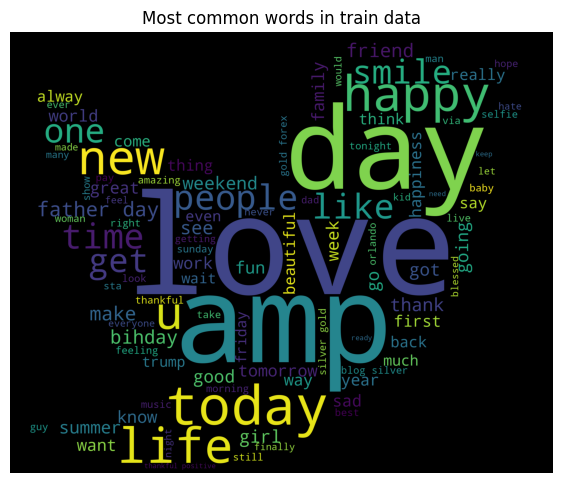

In [28]:
all_tweets_img = np.array(Image.open('images/all_tweets.png'))

all_tweets = ' '.join(X_train.tolist())

plt.figure(figsize=(7, 7))
wordcloud = WordCloud(
    stopwords=stop_words,
    max_words=100,
    mask=all_tweets_img,
).generate(all_tweets)

plt.title('Most common words in train data')
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

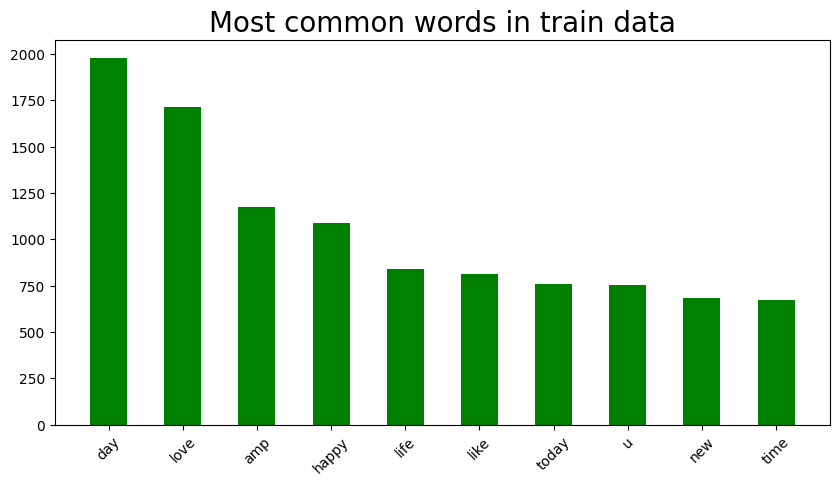

In [29]:
all_words = FreqDist(
    ' '.join(X_train).split()
).most_common(10)

all_words_data = pd.DataFrame(all_words, columns=['words', 'frequency'])

fig = plt.figure(figsize=(10,5))
plt.bar(
    all_words_data['words'].tolist(),
    all_words_data['frequency'].tolist(),
    width=0.5,
    color='green'
)

plt.title('Most common words in train data', fontsize=20)
plt.xticks(rotation=45)
plt.show()

#### Hatred data

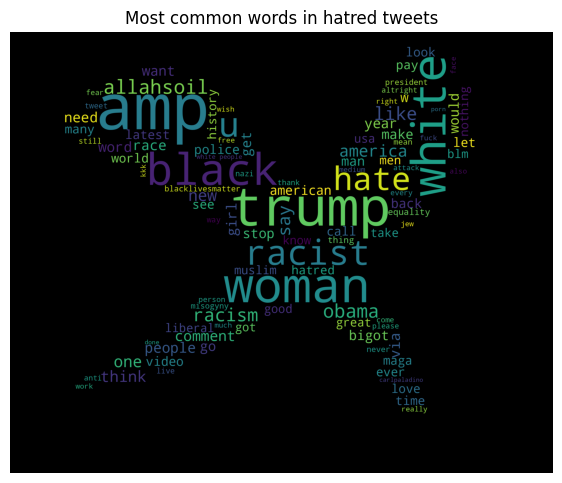

In [30]:
hatred_tweets_img = np.array(Image.open('images/hatred_tweets.png'))
hatred_tweets_data = train_data.loc[train_data['label'] == 1]

hatred_tweets = ' '.join(hatred_tweets_data['tweet_cleaned'].tolist())

plt.figure(figsize=(7, 7))
wordcloud = WordCloud(
    stopwords=stop_words,
    max_words=100,
    mask=hatred_tweets_img,
).generate(hatred_tweets)

plt.title('Most common words in hatred tweets')
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

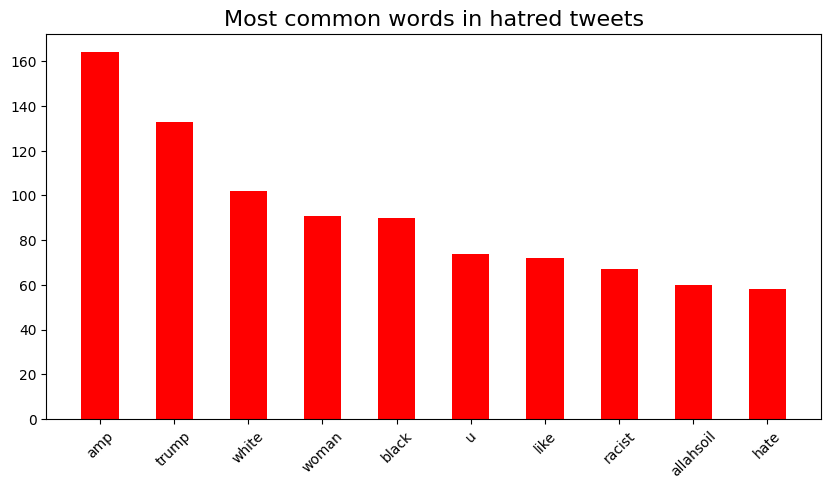

In [31]:
hatred_words = FreqDist(
    ' '.join(train_data.loc[train_data['label'] == 1]['tweet_cleaned']).split()
).most_common(10)

hatred_df = pd.DataFrame(hatred_words, columns=['words', 'frequency'])

fig = plt.figure(figsize=(10,5))
plt.bar(
    hatred_df['words'].tolist(),
    hatred_df['frequency'].tolist(),
    width=0.5,
    color='red'
)

plt.title('Most common words in hatred tweets', fontsize=16)
plt.xticks(rotation=45)
plt.show()

#### Non-hatred data

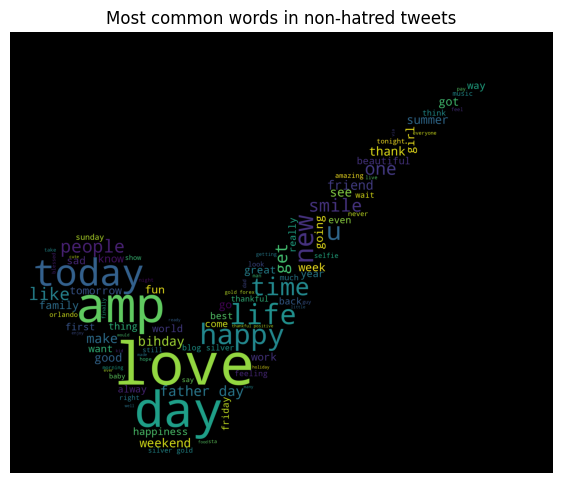

In [32]:
non_hatred_tweets_img = np.array(Image.open('images/non-hatred_tweets.png'))
non_hatred_tweets_data = train_data.loc[train_data['label'] == 0]

non_hatred_tweets = ' '.join(non_hatred_tweets_data['tweet_cleaned'].tolist())

plt.figure(figsize=(7, 7))
wordcloud = WordCloud(
    stopwords=stop_words,
    max_words=100,
    mask=non_hatred_tweets_img,
).generate(non_hatred_tweets)

plt.title('Most common words in non-hatred tweets')
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

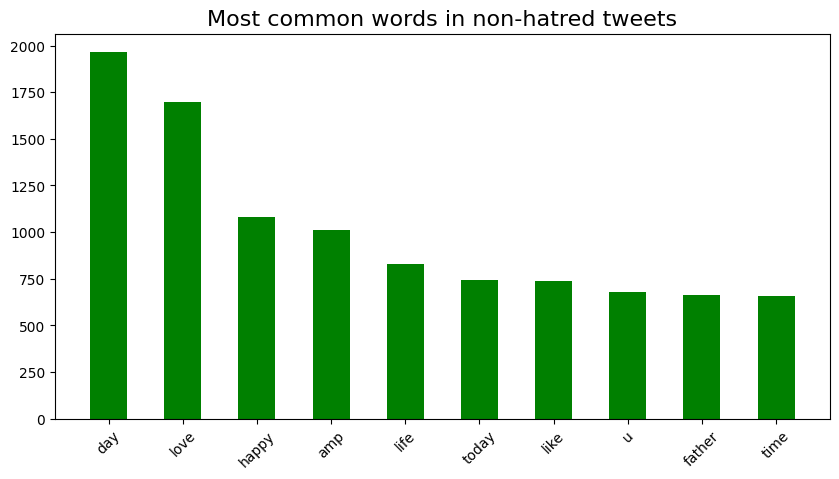

In [33]:
non_hatred_words = FreqDist(
    ' '.join(train_data.loc[train_data['label'] == 0]['tweet_cleaned']).split()
).most_common(10)

non_hatred_df = pd.DataFrame(non_hatred_words, columns=['words', 'frequency'])

fig = plt.figure(figsize=(10,5))
plt.bar(
    non_hatred_df['words'].tolist(),
    non_hatred_df['frequency'].tolist(),
    width=0.5,
    color='green'
)

plt.title('Most common words in non-hatred tweets', fontsize=16)
plt.xticks(rotation=45)
plt.show()

#### Hatred vs Non-hatred data

In [34]:
(non_hatred, hatred) = train_data['label'].value_counts()
hatred_perc = hatred / (train_data.shape[0]) * 100
non_hatred_perc = non_hatred / (train_data.shape[0]) * 100

print(colored(f'Number of hatred tweets: {hatred:,} ({hatred_perc:.2f}%)', 'red'))
print(colored(f'Number of non-hatred tweets: {non_hatred:,} ({non_hatred_perc:.2f}%)', 'green'))

Number of hatred tweets: 1,405 (6.81%)
Number of non-hatred tweets: 19,236 (93.19%)


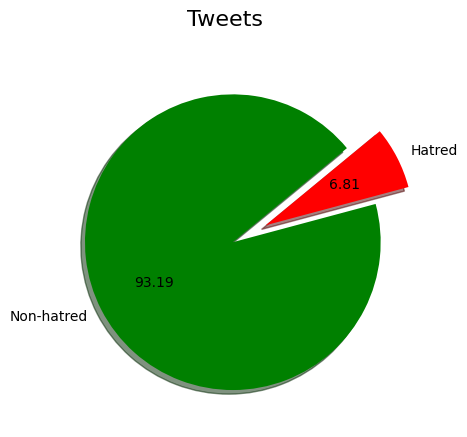

In [35]:
labels = 'Hatred', 'Non-hatred'

fig, ax = plt.subplots()
fig.suptitle(t='Tweets', fontsize=16)

ax.pie(
    x=[hatred, non_hatred],
    explode=(0.25, 0),
    labels=labels,
    colors=['Red', 'Green'],
    autopct='%.2f',
    shadow=True,
    startangle=15
);

From the graph, it can be seen that we have a problem with unbalanced classes where tweets that are characterized as tweets that do not contain hate speech are more prevalent in our training set (ratio 93.19% / 6.81%). The problem could be that our model adapts to the data and gives very good accuracy, but gives bad results on unknown data.

# Problem with imbalanced classes

As our training set contains unbalanced classes (ratio 93% - 7% in favor of tweets that do not contain hate speech), we have to apply some of the techniques of working with unbalanced classes.

- Oversampling (Adjusting a smaller set to a larger one)
  - RandomOverSampler
  - SMOTE
- Undersampling (Adjusting a larger set to a smaller one)
  - RandomUnderSampling
  - NearMiss
  - CondenseNearestNeighbour
- Combination Oversampling & Undersampling (Combination of the previous two)
  - SMOTEENN
- Imbalanced Ensemble
  - BalancedRandomForestClassifier

Before applying some of the models for working with data, it is necessary to transform our data from a textual to a numerical category using the TfidVectorizer class.
The `TF-IDF` (Term Frequency - Inverse Document Frequency) matrix uses the frequency of occurrence of a word to determine how relevant a given word is in a given document.

In [36]:
X_train.shape, X_test.shape

((20645,), (8848,))

In [37]:
tf_idf_vectorizer = TfidfVectorizer(max_features=3000)
tf_idf_vectorizer.fit(X_train)

X_train_tf_idf = tf_idf_vectorizer.transform(X_train)
X_test_tf_idf = tf_idf_vectorizer.transform(X_test)

X_train_tf_idf.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [38]:
X_train_tf_idf.shape

(20645, 3000)

In [39]:
model_dtc = DecisionTreeClassifier(max_depth=6, min_samples_split=50, criterion='gini')

model_dtc.fit(X_train_tf_idf, Y_train)

DecisionTreeClassifier(max_depth=6, min_samples_split=50)

In [40]:
print(f'Accuracy: {model_dtc.score(X_test_tf_idf, Y_test):.3f}')

Accuracy: 0.942


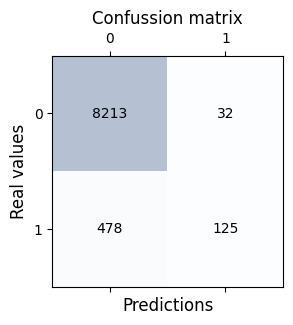

In [41]:
Y_pred = model_dtc.predict(X_test_tf_idf)

cm = confusion_matrix(Y_test, Y_pred)

(fig, ax) = plt.subplots(figsize=(3, 3))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='medium')

plt.xlabel('Predictions', fontsize=12)
plt.ylabel('Real values', fontsize=12)
plt.title('Confussion matrix', fontsize=12)
plt.show()

In [42]:
print(classification_report_imbalanced(Y_test, Y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.95      1.00      0.21      0.97      0.45      0.22      8245
          1       0.80      0.21      1.00      0.33      0.45      0.19       603

avg / total       0.93      0.94      0.26      0.93      0.45      0.22      8848



From the confusion matrix and report above we can see that accuracy is not the real measurement, so the following step would be using some techniques for dealing with imbalanced classes mentioned previously

### SMOTE

In [43]:
imbalanced_model_smote = make_pipeline(TfidfVectorizer(), SMOTE(), MultinomialNB())

imbalanced_model_smote.fit(X_train, Y_train)

Y_pred_smote = imbalanced_model_smote.predict(X_test)

In [44]:
print(classification_report_imbalanced(Y_test, Y_pred_smote))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.91      0.84      0.95      0.88      0.77      8245
          1       0.41      0.84      0.91      0.55      0.88      0.76       603

avg / total       0.95      0.91      0.85      0.92      0.88      0.77      8848



### RandomOverSampler

In [45]:
imbalanced_model_ros = make_pipeline(TfidfVectorizer(), RandomOverSampler(), MultinomialNB())

imbalanced_model_ros.fit(X_train, Y_train)

Y_pred_ros = imbalanced_model_ros.predict(X_test)

In [46]:
print(classification_report_imbalanced(Y_test, Y_pred_ros))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.91      0.85      0.95      0.88      0.78      8245
          1       0.40      0.85      0.91      0.55      0.88      0.77       603

avg / total       0.95      0.90      0.86      0.92      0.88      0.78      8848



### RandomUnderSampler

In [47]:
imbalanced_model_rus = make_pipeline(TfidfVectorizer(), RandomUnderSampler(), MultinomialNB())

imbalanced_model_rus.fit(X_train, Y_train)

Y_pred_rus = imbalanced_model_rus.predict(X_test)

In [48]:
print(classification_report_imbalanced(Y_test, Y_pred_rus))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.82      0.91      0.90      0.86      0.74      8245
          1       0.27      0.91      0.82      0.42      0.86      0.75       603

avg / total       0.94      0.83      0.90      0.87      0.86      0.74      8848



`RandomUnderSampler` gives the worst results out of 3 tested, and since `RandomOverSampler` and `SMOTE` are giving pretty much the same results we will use `RandomOverSampler` (easier to work with text data)

In [49]:
ros = RandomOverSampler(random_state=0, sampling_strategy='minority')

(X_resampled_ros, Y_resampled_ros) = ros.fit_resample(np.array(X_train).reshape(-1, 1), Y_train)

X_resampled_ros_list = [item for row in X_resampled_ros for item in row]

In [50]:
X_resampled_ros_df = pd.Series(X_resampled_ros_list)

# Saving new data for classification algorithms

In [51]:
tf_idf_vectorizer_classification = TfidfVectorizer(max_features=3000)
tf_idf_vectorizer_classification.fit(X_resampled_ros_df)

X_resampled_ros_tf_idf = tf_idf_vectorizer_classification.transform(X_resampled_ros_df)
X_test_ros_tf_idf = tf_idf_vectorizer_classification.transform(X_test)

In [52]:
train_tf_idf_ros_df = pd.concat(
    [
        pd.DataFrame(
            X_resampled_ros_tf_idf.toarray(),
            columns=tf_idf_vectorizer_classification.get_feature_names_out()
        ),
        Y_resampled_ros
    ],
    axis=1
)

train_tf_idf_ros_df.head()

,able,ableism,abou,absence,absolutely,absurd,abt,abuse,abusive,acceptable,...,yup,yur,zero,zille,zionazi,zionazis,zionism,zionist,zuma,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [53]:
Y_test.index = range(0, Y_test.shape[0])

In [54]:
test_tf_idf_ros_df = pd.concat(
    [
        pd.DataFrame(
            X_test_ros_tf_idf.toarray(),
            columns=tf_idf_vectorizer_classification.get_feature_names_out()
        ),
        Y_test
    ],
    axis=1
)

print(test_tf_idf_ros_df.shape)
test_tf_idf_ros_df.head()

(8848, 3001)


,able,ableism,abou,absence,absolutely,absurd,abt,abuse,abusive,acceptable,...,yup,yur,zero,zille,zionazi,zionazis,zionism,zionist,zuma,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [55]:
train_tf_idf_ros_df.to_csv('dataset/classification/train.csv', index=False)
test_tf_idf_ros_df.to_csv('dataset/classification/test.csv', index=False)

# Saving new data for clustering algorithms

In [56]:
X_test.index = range(X_resampled_ros_df.shape[0], X_resampled_ros_df.shape[0] + X_test.shape[0])
X_test

38478                              tag dwayne johnson provocative statement scared agent like shame
38479                                                                 excited use oneblade phillips
38480                       thanks autism film plan hotting amp andrew hard work coming together xx
38481                                   right enjoying every single day yong forever th anniversary
38482                                                                                    thanks jan
                                                    ...                                            
47321                        prayer victim orlando shooting victim especially lgbt community tragic
47322    top food item seasonal affective disorder patient must avoid peh busselton hoba wellington
47323          bit colour brighten grey morning kidsroom scandi fermliving dollshouse retrotoys toy
47324                           chick fil heard boy say let pretend terrorist attack signofthetimes


In [57]:
df_combined = pd.concat(
    [X_resampled_ros_df, X_test]
)
df_combined

0                                  wait stage look awesome see pm cmafest drinkingwithdolly flockon
1              bbc news orlando gay nightclub shooting killed suspect omar mateen love love get smh
2                                                                                    friend netflix
3                                                  ceain area yeah seen video seeing little kid cry
4                                          thnx pilot nick amazing experience grandcanyon afternoon
                                                    ...                                            
47321                        prayer victim orlando shooting victim especially lgbt community tragic
47322    top food item seasonal affective disorder patient must avoid peh busselton hoba wellington
47323          bit colour brighten grey morning kidsroom scandi fermliving dollshouse retrotoys toy
47324                           chick fil heard boy say let pretend terrorist attack signofthetimes


In [58]:
tf_idf_vectorizer_clustering = TfidfVectorizer(max_features=3000)
tf_idf_vectorizer_clustering.fit(df_combined)

clustering_ros_tf_idf = tf_idf_vectorizer_clustering.transform(df_combined)

In [59]:
tf_idf_ros_df = pd.DataFrame(
    clustering_ros_tf_idf.toarray(),
    columns=tf_idf_vectorizer_clustering.get_feature_names_out()
)

tf_idf_ros_df

,able,ableism,abou,absolutely,abt,abuse,abusive,accept,acceptable,accepting,...,yummy,yup,yur,zero,zille,zionazi,zionazis,zionism,zionist,zuma
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47321,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
47322,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
47323,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
47324,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [60]:
tf_idf_ros_df.to_csv('dataset/clustering/clustering.csv', index=False)

# Saving new data for association rules

In [61]:
association_rules_data = X_train.copy()
association_rules_data

22001                        wait stage look awesome see pm cmafest drinkingwithdolly flockon
18793    bbc news orlando gay nightclub shooting killed suspect omar mateen love love get smh
14980                                                                          friend netflix
10457                                        ceain area yeah seen video seeing little kid cry
29761                                thnx pilot nick amazing experience grandcanyon afternoon
                                                 ...                                         
19554                                                     downtime lunchtime unique inclusive
15531                                                               going mexico day vacation
240                                                sanjapan animeconvention see guy september
24219              washtimes anybody dropped ball gop passing law keep gun mateens crazy hand
31490                  good news job interview thursday exci

In [62]:
vectorizer_association_rules = TfidfVectorizer(max_features=3000)
vectorizer_association_rules.fit(association_rules_data)

vectorizer_association_rules_t = tf_idf_vectorizer_clustering.transform(association_rules_data)

In [63]:
matrix = np.where(vectorizer_association_rules_t.toarray() > 0, 1, 0)
association_rules_df = pd.DataFrame(
    matrix,
    columns=vectorizer_association_rules.get_feature_names_out()
)

association_rules_df

,aap,able,absolutely,abt,abuse,accept,acceptable,accepted,access,accessory,...,young,youth,youtube,youtuber,yoy,yr,yum,yummy,zelda,zen
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20640,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20641,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20642,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20643,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [64]:
association_rules_Y = Y_train.copy()
association_rules_Y.index = range(0, association_rules_Y.shape[0])

association_rules_df['label'] = association_rules_Y
association_rules_df

,aap,able,absolutely,abt,abuse,accept,acceptable,accepted,access,accessory,...,youth,youtube,youtuber,yoy,yr,yum,yummy,zelda,zen,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20640,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20641,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20642,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20643,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [65]:
association_rules_non_hatred = association_rules_df.loc[association_rules_df['label'] == 0]
association_rules_non_hatred.drop('label', axis=1, inplace=True)
association_rules_non_hatred

<ipython-input-65-4e7ce5a5d165>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  association_rules_non_hatred.drop('label', axis=1, inplace=True)


,aap,able,absolutely,abt,abuse,accept,acceptable,accepted,access,accessory,...,young,youth,youtube,youtuber,yoy,yr,yum,yummy,zelda,zen
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20640,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20641,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20642,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20643,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [66]:
association_rules_hatred = association_rules_df.loc[association_rules_df['label'] == 1]
association_rules_hatred.drop('label', axis=1, inplace=True)
association_rules_hatred

<ipython-input-66-be16366b7553>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  association_rules_hatred.drop('label', axis=1, inplace=True)


,aap,able,absolutely,abt,abuse,accept,acceptable,accepted,access,accessory,...,young,youth,youtube,youtuber,yoy,yr,yum,yummy,zelda,zen
14,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
33,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
72,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
93,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20588,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20598,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20606,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20614,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [67]:
association_rules_df.to_csv('dataset/association_rules/association_rules.csv', index=False)
association_rules_non_hatred.to_csv('dataset/association_rules/non_hatred.csv', index=False)
association_rules_hatred.to_csv('dataset/association_rules/hatred.csv', index=False)